<a href="https://colab.research.google.com/github/Rjpiit/Image-processing-and-Audio-Reconstruction/blob/master/task3_previous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

url = "https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg"
response = requests.get(url)

# Save the image
with open("image.jpg", "wb") as file:

    file.write(response.content)

print("Image downloaded successfully!")


Image downloaded successfully!


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

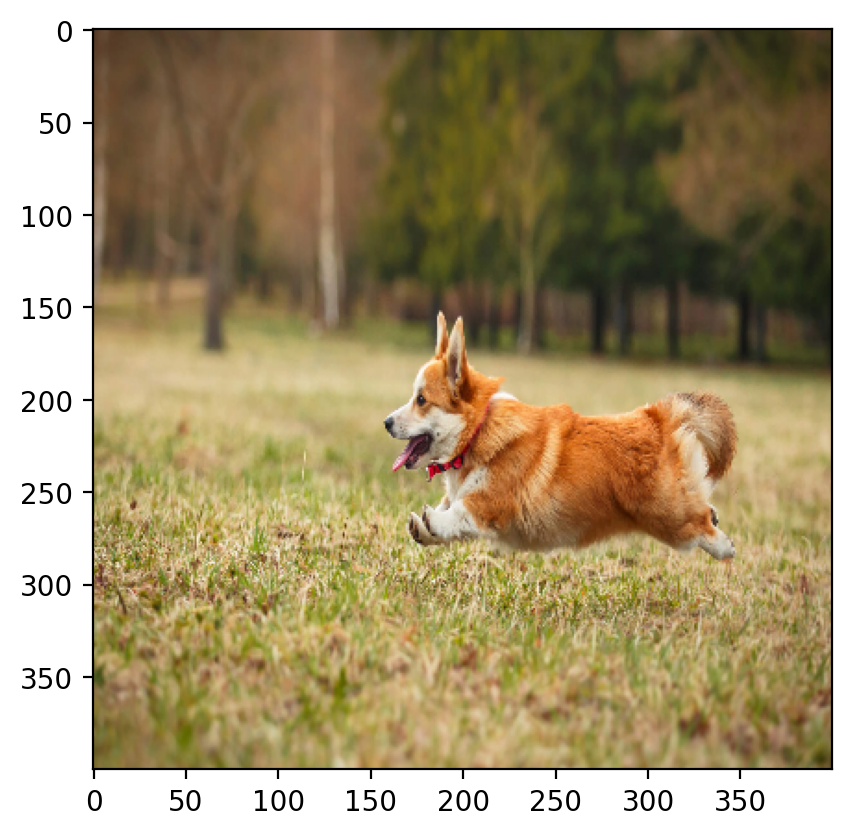

In [ ]:
import cv2

image = cv2.imread('image.jpg')

original_image = cv2.resize(image, (400, 400))

original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.imshow(original_image_rgb)


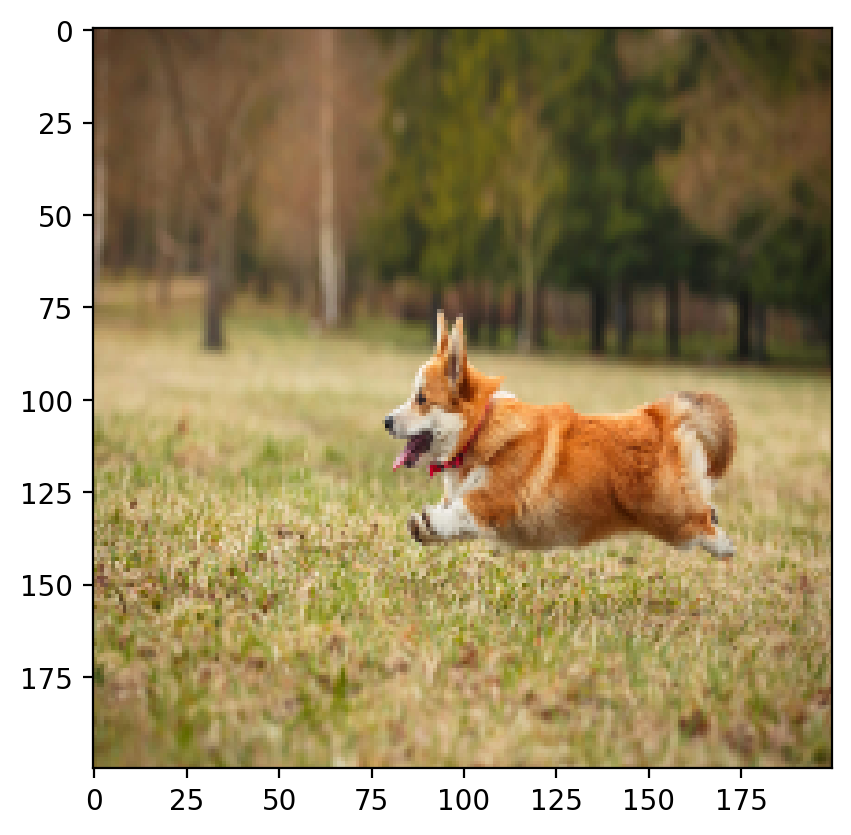

In [ ]:
resized_image = cv2.resize(original_image, (200, 200))

resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

plt.imshow(resized_image_rgb)


In [ ]:
import torchvision.transforms as T
img = T.ToTensor()(resized_image_rgb)
print(img.shape)

torch.Size([3, 200, 200])


In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3228, 0.3583, 0.3898,  ..., 0.2874, 0.2835, 0.2874],
         [0.3307, 0.3701, 0.3898,  ..., 0.2953, 0.2913, 0.2992],
         [0.3307, 0.3661, 0.3819,  ..., 0.2913, 0.2835, 0.2913],
         ...,
         [0.4606, 0.4803, 0.4921,  ..., 0.2795, 0.3543, 0.3622],
         [0.4803, 0.5039, 0.5000,  ..., 0.3504, 0.4055, 0.3701],
         [0.4843, 0.5197, 0.5118,  ..., 0.4252, 0.4409, 0.3898]],

        [[0.2165, 0.2520, 0.2795,  ..., 0.2244, 0.2283, 0.2283],
         [0.2244, 0.2559, 0.2756,  ..., 0.2323, 0.2362, 0.2323],
         [0.2244, 0.2559, 0.2717,  ..., 0.2323, 0.2283, 0.2323],
         ...,
         [0.4055, 0.4370, 0.4449,  ..., 0.2480, 0.3071, 0.2953],
         [0.4134, 0.4528, 0.4488,  ..., 0.2992, 0.3307, 0.2992],
         [0.4134, 0.4488, 0.4528,  ..., 0.3465, 0.3583, 0.3228]],

        [[0.1496, 0.1693, 0.1969,  ..., 0.1339, 0.1220, 0.1220],
         [0.1417, 0.1772, 0.1929,  ..., 0.1417, 0.1339, 0.1299],
         [0.1417, 0.1732, 0.1890,  ..., 0.1457, 0.1299, 0.

In [ ]:
img = img.to(device)

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y



In [ ]:
img_X, img_Y = create_coordinate_map(img)

img_X.shape, img_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()


In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)



In [ ]:
X_rff = create_rff_features(img_X_scaled, 15000, 0.008)
X_rff.shape

torch.Size([40000, 15000])

In [ ]:
# net = LinearModel(X_rff.shape[1], 3)
# net.to(device)

# train(net, 0.005, X_rff, img_Y, 2500)

In [ ]:
img_Y.shape

torch.Size([40000, 3])

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Assuming LinearModel and train functions are already defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to create new upsampled grid (400x400) for prediction
def create_new_grid(size):
    x = np.linspace(0, 1, size)
    y = np.linspace(0, 1, size)
    xv, yv = np.meshgrid(x, y)
    grid = np.stack([xv.flatten(), yv.flatten()], axis=1)
    return torch.tensor(grid, dtype=torch.float32).to(device)

# Use the trained network to predict pixel values for 400x400 image
def predict_image(net, X_scaled, num_features, sigma, target_size):
    # Create random Fourier features for the 400x400 image
    X_rff = create_rff_features(X_scaled, num_features, sigma)

    # Predict the pixel values
    predictions = net(X_rff).cpu().numpy()

    # Reshape predictions to the new image size
    predictions = predictions.reshape(target_size, target_size, -1)

    return predictions

# Assuming img_X_scaled, img_Y are already defined for 200x200 image training
# X_scaled: coordinates of original image (200x200) scaled between 0 and 1
# img_Y: pixel values of original image (200x200)
# Train the model (example with 200x200 image)
in_features = 15000  # Example number of random features
out_features = 3  # RGB values
net = LinearModel(in_features, out_features).to(device)
lr = 0.001
epochs = 1000

# Train the model
train(net, lr, X_rff, img_Y, epochs)



Epoch 0 loss: 0.238786
Epoch 100 loss: 0.155850
Epoch 200 loss: 0.102098
Epoch 300 loss: 0.067972
Epoch 400 loss: 0.046967
Epoch 500 loss: 0.034390
Epoch 600 loss: 0.027037
Epoch 700 loss: 0.022797
Epoch 800 loss: 0.020326
Epoch 900 loss: 0.018811


0.01780112087726593

In [ ]:
# Create new grid for 400x400
new_grid = create_new_grid(400)



In [ ]:
# Predict pixel values for the new 400x400 image
predicted_image = predict_image(net, new_grid, 15000, 0.008, 400)


plt.imshow(predicted_image)



In [ ]:
# import torch.nn.functional as F

# def plot_reconstructed_and_original_image(original_img, net, X, title=""):
#     """
#     Plots the original and reconstructed images side by side, resizing them if necessary.

#     Args:
#     - original_img: torch.Tensor of shape (num_channels, height, width), the original image (e.g., 200x200).
#     - net: torch.nn.Module, the neural network model used for reconstruction.
#     - X: torch.Tensor of shape (num_samples, 2), the input to the network.
#     - title: str, optional title for the plot.
#     """
#     original_channels, original_height, original_width = original_img.shape
#     net.eval()  # Set the network to evaluation mode

#     with torch.no_grad():  # Disable gradient computation
#         outputs = net(X)  # Forward pass through the network
#         # Assuming outputs are (num_channels, height, width) and might need reshaping
#         reconstructed_height, reconstructed_width = 400, 400  # Expected size of the reconstructed image
#         outputs = outputs.reshape(original_channels, reconstructed_height, reconstructed_width)

#     # Resize the original image to match the size of the reconstructed image
#     resized_original_img = F.interpolate(original_img.unsqueeze(0), size=(reconstructed_height, reconstructed_width), mode='bilinear', align_corners=False).squeeze(0)

#     # Plot the original and reconstructed images
#     fig = plt.figure(figsize=(6, 4))
#     gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

#     ax0 = plt.subplot(gs[0])
#     ax1 = plt.subplot(gs[1])

#     # Plot the reconstructed image
#     ax0.imshow(outputs.cpu().permute(1, 2, 0))  # permute for height x width x channels format
#     ax0.set_title("Reconstructed Image")

#     # Plot the resized original image
#     ax1.imshow(resized_original_img.cpu().permute(1, 2, 0))
#     ax1.set_title("Original Image (Resized)")

#     # Remove axis ticks for both images
#     for a in [ax0, ax1]:
#         a.axis("off")

#     # Set an optional title for the figure
#     fig.suptitle(title, y=0.9)
#     plt.tight_layout()
